## The Project description ##
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process.

## Starting ##

In [6]:
import zipfile

from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

In [7]:
def is_keyword_in_img(keyword, image):
    """returns True if there is an occurence of keyword in image, otherwise False.
    :param keyword: a single word of string type;
    :param image: A PIL.Image object."""
    image = image.convert('1') #Binarize the image in order to improve the performance of the OCR
    text = pytesseract.image_to_string(image)
    if keyword in text:
        return True
    return False
    

In [8]:
def faces_in_img(image):
    """detects all faces in image.
    :param image: A cv2 image object;
    :returns: A list of PIL.Image objects, each representing a face cropped from image, an empty list if the image 
    doesn't contain any faces."""
    IMAGE = image.copy()
    gray_IMAGE = cv.cvtColor(IMAGE, cv.COLOR_BGR2GRAY) #convert it to grayscale in order to enhance the faces detection performance
    faces = face_cascade.detectMultiScale(gray_IMAGE, 1.35) #return a numpy array of boxes (of each face)
    
    if type(faces) is tuple: #In this case, no faces have been detected (faces = ()). We need toreturn an empty list
        return []
    else:  #Here, faces is of numpy.ndarray type. That means faces have been detected.
        face_boxes = faces.tolist() #convert the numpy.ndarray faces into a list of lists (boxes)
        pil_IMAGE = Image.fromarray(IMAGE).convert('RGB') #Our image as a PIL.Image object

        IMAGES = []
        for box in face_boxes:
            true_box = (box[0], box[1], box[0] + box[2], box[1] + box[3])
            IMG = pil_IMAGE.crop(true_box)
            IMG.thumbnail((120, 120))
            IMAGES.append(IMG)

        return IMAGES

In [9]:
def image_with_text(text = ''):
    """returns a white image with text writted on it.
    :param text: A string object."""
    width = 120 * 5
    height = 20
    white_image = Image.new('RGB', (width, height), color = 'white')
    #Set up the drawing object to write on our white image
    drawing_object = ImageDraw.Draw(white_image)
    #Set up the font type and font size we'll use
    fnt = ImageFont.truetype('readonly/fanwood-webfont.ttf', 20)
    #Now, let's write with our drawing object
    drawing_object.text((0, 0), text, fill = 'black', font = fnt)
    
    return white_image

In [10]:
def black_contact_sheet(image_lst):
    """return a contact sheet for a given list of images (to make a contact sheet of faces).
    :param image_lst: A list of PIL.Image objects;
    :returns: A contact sheet with all the images in image_lst, a PIL.Image object."""
    
    import math
    width = 120 * 5
    height = 120 * math.ceil(len(image_lst) / 5)
    contact_sheet = Image.new('RGB', (width, height), color = 'black')
    
    x = 0
    y = 0
    for image in image_lst:
        contact_sheet.paste(image, (x, y))
        #Now, let's update the positions
        if x + 120 == width:
            x = 0
            y += 120
        else:
            x += 120
    
    return contact_sheet


In [11]:
def search(keyword, zip_file_name):
    """Our final function which takes a keyword as parameter and search for it through all the images in the zip file name, 
    then display the final wanted contact sheet from all the images contained in that zip file.
    :param keyword: A single word of string type;
    :param zip_file_name: can only be 'small_img.zip' or 'images.zip';
    :returns: None."""
    
    #Extract all the images to a folder named IMAGES
    with zipfile.ZipFile('readonly/' + zip_file_name, 'r') as z:
        z.extractall('IMAGES') #extracts all the images in zip_file_name and creates a folder named IMAGES with all these image files inside
        file_names = z.namelist() #z.namelist() is a list of all the image file names that are in zip_file_name

    #Initialise contact_sheet_so_far (our accumulator variable here) as a white pixel
    contact_sheet_so_far = Image.new('RGB', (1,1), color = 'white')
    
    for img_name in file_names:
        img = Image.open('IMAGES/' + img_name) #A PIL.Image object
        cv_img = cv.imread('IMAGES/' + img_name)
        lst_of_imgs = faces_in_img(cv_img)  #List of detected image faces of PIL.Image object
        
        if is_keyword_in_img(keyword, img):
            if lst_of_imgs != []: #When there are faces in img
                white_space_img = image_with_text()
                text_img = image_with_text('Results found in file {}'.format(img_name))
                contact_sheet = black_contact_sheet(lst_of_imgs)
                new_contact_sheet = Image.new('RGB', (contact_sheet.width, contact_sheet_so_far.height + text_img.height*3 + contact_sheet.height), color = 'white')
                new_contact_sheet.paste(contact_sheet_so_far, (0, 0))
                new_contact_sheet.paste(white_space_img, (0, contact_sheet_so_far.height))
                new_contact_sheet.paste(text_img, (0, contact_sheet_so_far.height + text_img.height)) #Since white_space_img.height = text_img.height
                new_contact_sheet.paste(white_space_img, (0, contact_sheet_so_far.height + text_img.height*2))
                new_contact_sheet.paste(contact_sheet, (0, contact_sheet_so_far.height + text_img.height*3))
                contact_sheet_so_far = new_contact_sheet.copy()
            else:               #when there are no faces in img
                white_space_img = image_with_text()
                text_img = image_with_text('Results found in file {}'.format(img_name))
                text2_img = image_with_text('But there were no faces in that file!')
                new_contact_sheet = Image.new('RGB', (contact_sheet.width, contact_sheet_so_far.height + text_img.height*3), color = 'white')
                new_contact_sheet.paste(contact_sheet_so_far, (0, 0))
                new_contact_sheet.paste(white_space_img, (0, contact_sheet_so_far.height))
                new_contact_sheet.paste(text_img, (0, contact_sheet_so_far.height + text_img.height)) #Since white_space_img.height = text_img.height
                new_contact_sheet.paste(text2_img, (0, contact_sheet_so_far.height + text_img.height*2))
                contact_sheet_so_far = new_contact_sheet.copy()

    display(contact_sheet_so_far)

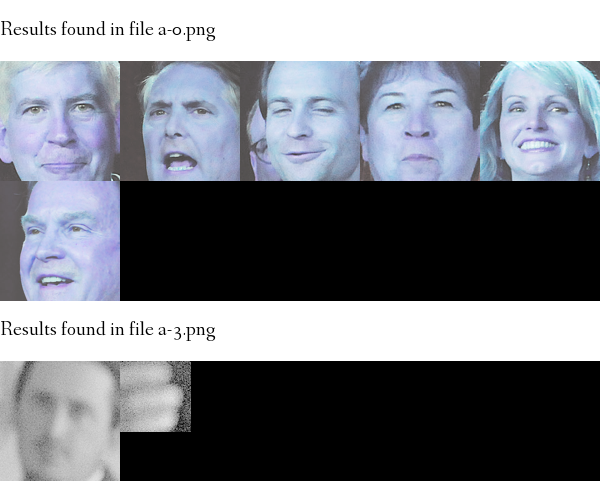

In [16]:
#Using the small_img.zip file, I search for the string keyword "Christopher"
search("Christopher", 'small_img.zip')

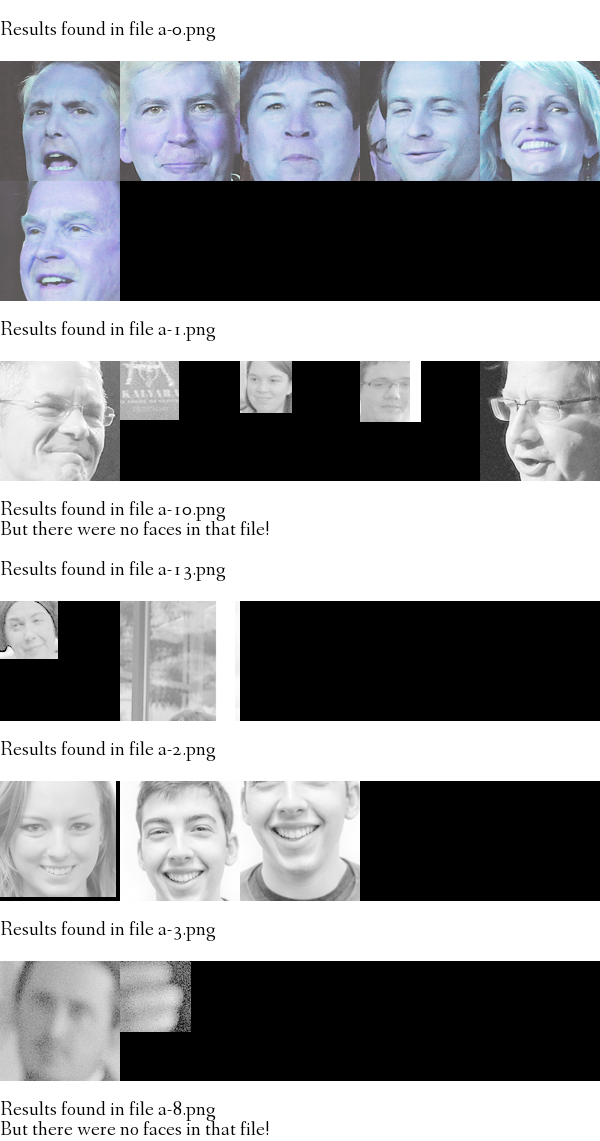

In [14]:
#Using the images.zip file, I search for the string keyword "Mark"
search("Mark", 'images.zip')